### Kaggle Data Science BOWL 2017 

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
#import seaborn as sns
import os
import glob
import cv2
#from sklearn.cross_validation import KFold
import dicom
%matplotlib inline
#p = sns.color_palette()
import time
from glob import glob
import h5py

# get package versions
def get_version(*vars):
    for var in vars:
        module = __import__(var)    
        print '%s: %s' %(var,module.__version__)
    
# package version    
get_version('numpy','matplotlib','cv2','sklearn')

numpy: 1.11.2
matplotlib: 1.5.1
cv2: 3.1.0
sklearn: 0.18.1


### presets

In [3]:
path2luna="/media/mra/win7/data/misc/kaggle/datascience2017/LUNA2016/"
subsets=glob(path2luna+'*.hdf5')

print 'total subsets: ', len(subsets)

total subsets:  10


### utils

In [4]:


def array_stats(X):
    X=np.asarray(X)
    print 'array shape: ',X.shape, X.dtype
    #print 'min: %.3f, max:%.3f, avg: %.3f, std:%.3f' %(np.min(X),np.max(X),np.mean(X),np.std(X))
    print 'min: {}, max: {}, avg: {:.3}, std:{:.3}'.format( np.min(X),np.max(X),np.mean(X),np.std(X))
    
def grays_to_RGB(img):
    # turn 2D grayscale image into grayscale RGB
    return np.dstack((img, img, img))



def image_with_mask(img, mask,color=(0,255,0)):
    maximg=np.max(img)    
    img=np.asarray(img,dtype='float32')
    img=np.asarray((img/maximg)*255,dtype='uint8')
    mask=np.asarray(mask,dtype='uint8') 
    if np.max(mask)==1:
        mask=mask*255

    # returns a copy of the image with edges of the mask added in red
    if len(img.shape)==2:	
	img_color = grays_to_RGB(img)
    else:
	img_color =img

    mask_edges = cv2.Canny(mask, 100, 200) > 0
    img_color[mask_edges, 0] = color[0]  # set channel 0 to bright red, green & blue channels to 0
    img_color[mask_edges, 1] = color[1]
    img_color[mask_edges, 2] = color[2]
    img_color=img_color#/float(np.max(img))
    return img_color

def disp_img_2masks(img,mask1,mask2,r=1,c=1,d=0,indices=None):
    if mask1 is None:
        mask1=np.zeros(img.shape,dtype='uint8')
    if mask2 is None:
        mask2=np.zeros(img.shape,dtype='uint8')
        
    N=r*c    
    if d==2:
        # convert to N*C*H*W
        img=np.transpose(img,(2,0,1))
        img=np.expand_dims(img,axis=1)
        
        mask1=np.transpose(mask1,(2,0,1))
        mask1=np.expand_dims(mask1,axis=1)

        mask2=np.transpose(mask2,(2,0,1))
        mask2=np.expand_dims(mask2,axis=1)
        
    if indices is None:    
        # random indices   
        n1=np.random.randint(img.shape[0],size=N)
    else:
        n1=indices
    
    I1=img[n1,0]
    #M1=mask1[n1,0]
    M1=np.zeros(I1.shape,dtype='uint8')
    for c1 in range(mask1.shape[1]):
        M1=np.logical_or(M1,mask1[n1,c1,:])    
    #M2=mask2[n1,0]
    M2=np.zeros(I1.shape,dtype='uint8')
    for c1 in range(mask2.shape[1]):
        M2=np.logical_or(M2,mask2[n1,c1,:])    
    
    C1=(0,255,9)
    C2=(255,0,0)
    for k in range(N):    
        imgmask=image_with_mask(I1[k],M1[k],C1)
        imgmask=image_with_mask(imgmask,M2[k],C2)
        plt.subplot(r,c,k+1)
        plt.imshow(imgmask)
        plt.title(n1[k])
    plt.show()            
    #return n1      
    
def normalize(X):    
    # normalization
    MIN_BOUND = -1000.0
    MAX_BOUND = 400.0
    X= (X- MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    X[X>1] = 1.
    X[X<0] = 0.    
    return X            

## sample patinet 

61
1.3.6.1.4.1.14519.5.2.1.6279.6001.250397690690072950000431855143.mhd
array shape:  (246, 512, 512) int16
min: -3024, max: 3071, avg: -9.62e+02, std:1.15e+03
array shape:  (246, 512, 512) int16
min: 0, max: 1, avg: 8.31e-05, std:0.00912
[106 107 108 109 119 120 121 127 128 129 134 135 136 145 146 147]


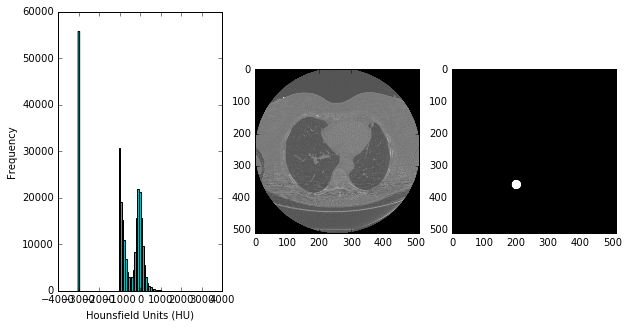

In [5]:

nb_scans=[]
for ss in subsets[1:2]:
    ff=h5py.File(ss,'r')
    ids=ff.keys()
    nb_scans.append(len(ff))
    #ff.close
print np.sum(nb_scans)
    
# load scan
nn=1
ids[nn]="1.3.6.1.4.1.14519.5.2.1.6279.6001.250397690690072950000431855143.mhd"
print ids[nn]
X,Y=ff[ids[nn]]
array_stats(X)
array_stats(Y)

nz_masks=np.where(np.sum(Y,axis=(1,2))>0)[0]
print nz_masks
sn=nz_masks[0]

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.hist(X[sn].flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")

# Show some slice in the middle
plt.subplot(1,3,2)
plt.imshow(X[sn], cmap=plt.cm.gray)

plt.subplot(1,3,3)
plt.imshow(Y[sn], cmap=plt.cm.gray)

plt.show()

246


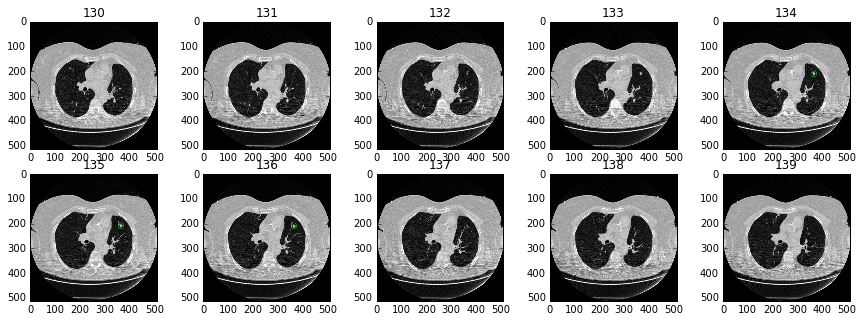

In [13]:
nb_slices=len(X)
print nb_slices
r,c=2,5
plt.figure(figsize=(15,5))
a,b=130,140
disp_img_2masks(normalize(X[:,np.newaxis,:]),Y[:,np.newaxis,:],None,r,c,0,range(a,b))

## sample patinet non-cancer

In [ ]:
r=1 # row

# get patinet id and cancer status
p_id=df_train.id[r] # patient id
p_c=df_train.cancer[r] # patinet cancer
print 'patient id: %s, cancer: %s' %(p_id,p_c)

# load scan
scan=load_scan(path2data+p_id)
X = get_pixels_hu(scan)
array_stats(X)

sn=len(X)/2
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.hist(X[sn].flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")

# Show some slice in the middle
plt.subplot(1,2,2)
plt.imshow(X[sn], cmap=plt.cm.gray)
plt.show()

### Downsample

In [ ]:
h,w=128,128
# transpose to h,w,z
X=np.transpose(X,(1,2,0))
# resize
Xr=cv2.resize(X, (w, h), interpolation=cv2.INTER_CUBIC)
# transpose to z,h,w
Xr=np.transpose(Xr,(2,0,1))
array_stats(Xr)

In [ ]:
r,c=nb_slices/5,5
f, plots = plt.subplots(r, c, sharex='all', sharey='all', figsize=(15, 120))
print 'wait ...'
for i in range(nb_slices):
    plots[i // c, i % c].axis('off')
    plots[i // c, i % c].imshow(Xr[i], cmap=plt.cm.bone)

## K-fold cross validation

In [ ]:
# stack images and labels
def stack_data(df,indices,(h,w)):
    X=[]
    y=[]
    for r in (indices):
        # get patinet id and cancer status
        p_id=df_train.id[r] # patient id
        p_c=df_train.cancer[r] # patinet cancer

        # load scan
        scan=load_scan(path2data+p_id)
        X1 = get_pixels_hu(scan)
        nb_slices=len(X1)
        
        # resize
        Xr=np.zeros((nb_slices,h,w),dtype=X1.dtype)
        for k1 in range(nb_slices):
            Xr[k1]=cv2.resize(X1[k1], (w, h), interpolation=cv2.INTER_CUBIC)
        
        print 'patient %s id: %s, cancer: %s, nb slices: %s' %(r,p_id,p_c,Xr.shape[0])        
        X.append(Xr)
        y.append(p_c)
    return X,y  


# total subjects
nb_sbj=len(df_train)

# n-fold cross validation
kf = KFold(nb_sbj, n_folds=5)
foldn=0


for train_indices, test_indices in kf:
    foldn=foldn+1 # fold number
    print 'processing fold%s, wait ...' %foldn
    #print("train: %s   val: %s" % (train_indices, test_indices))
    X_train,y_train=stack_data(df_train,train_indices,(h,w))
    X_test,y_test=stack_data(df_train,test_indices,(h,w))
    print len(X_train),len(y_train)
    print len(X_test),len(y_test)
    
    print 'wait to save ...'
    # create folder 
    path2nfolds=path2output+'fold'+str(foldn)+'/'
    if  not os.path.exists(path2nfolds):
        os.makedirs(path2nfolds)
        print 'folder created'
    np.savez(path2nfolds+'train', X=X_train,Y=y_train)
    np.savez(path2nfolds+'test', X=X_test,Y=y_test)
    
    print 'flod %s saved' %foldn 
    print '-' *50